In [44]:
import pandas as pd
from sodapy import Socrata
#aqui sacamos las tablas de datos de hospitales y desfibriladores 
client = Socrata("analisi.transparenciacatalunya.cat", None)

desfibriladors = client.get_all("wpud-ukyg")
hospitales = client.get_all("8gmd-gz7i")

df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitales = pd.DataFrame.from_records(hospitales) 


url = "https://www.idescat.cat/serveis/consultes/ca/censph_10_mun_2024.csv"

df_cens = pd.read_csv(url, sep=";", encoding="utf-8")
df_cens.head()

#df_desfibriladors

#imprimir los nomobres de todas las columnas
#print longitud and latitud columns and check for nan or inf values
print(df_desfibriladors[['longitud', 'latitud']].isnull().sum())
print(df_desfibriladors[['longitud', 'latitud']].isin([float('inf'), float('-inf')]).sum())
print(df_desfibriladors[['longitud', 'latitud']])

print(df_hospitales[['longitud', 'latitud']].isnull().sum())

longitud    340
latitud     340
dtype: int64
longitud    0
latitud     0
dtype: int64
          longitud      latitud
0      2.062119419  41.37295505
1              NaN          NaN
2      2.824795255  41.98315704
3      3.145100286  41.97106674
4              NaN          NaN
...            ...          ...
11489  2.014299404  41.29338658
11490          NaN          NaN
11491  1.772043672  41.26238549
11492  2.193316138  41.40464354
11493  1.623438287  41.58002076

[11494 rows x 2 columns]
longitud    0
latitud     0
dtype: int64


C:\Users\Ale\AppData\Local\Temp\ipykernel_6372\2696561299.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


In [3]:
df_clean=df_hospitales[df_hospitales["categoria"].str.contains("salut", na=False)]
df_clean = df_clean[["poblacio"]].copy()
df_clean["municipi"] = df_clean["poblacio"].str.upper().str.strip()
df_hospis = df_clean.groupby("municipi").size().reset_index(name="hosp_count")
#df_hospis

In [4]:
#df_cens

In [20]:

# Filter rows where edat == "total"
df_cens_total = df_cens[(df_cens["edat"] == "total") & (df_cens["sexe"] == "total")].copy()
df_cens_total = df_cens_total[df_cens_total["valor"] <= 5000000]
df_cens_total = df_cens_total.reset_index(drop=True)
df_cens_total = df_cens_total.rename(columns={"valor": "pob"})

# Keep only municipality name and population
df_cens_pop = df_cens_total[["municipi", "pob"]].copy()

# Clean municipality names for merging
df_cens_pop["municipi"] = df_cens_pop["municipi"].str.upper().str.strip()
#df_cens_pop

In [21]:

df_desfibriladors["municipi"] = df_desfibriladors["municipi"].str.upper().str.strip()
df_d_counts = df_desfibriladors.groupby("municipi").size().reset_index(name="desf_count")

df_merged = df_d_counts.merge(
    df_cens_pop[["municipi", "pob"]],
    left_on="municipi",
    right_on="municipi",
    how="left"
)

df_merged["desf_per_1000"] = df_merged["desf_count"] / df_merged["pob"] * 1000
#df_merged

In [22]:
#ahora voy a limpiar los datos, empiezo con desfibriladores
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = "carto/"

municipis = gpd.read_file(data_dir + "muni.json")

#municipis.plot(figsize=(8, 8), edgecolor="black")
print(municipis.columns)


#plt.show()


Index(['CODIMUNI', 'NOMMUNI', 'CAPMUNI', 'AREAM5000', 'CODICOMAR', 'NOMCOMAR',
       'CAPCOMAR', 'CODIVEGUE', 'NOMVEGUE', 'CAPVEGUE', 'CODIPROV', 'NOMPROV',
       'CAPPROV', 'geometry'],
      dtype='object')


In [9]:
municipis["NOMMUNI"] = municipis["NOMMUNI"].str.upper().str.strip()

des_muni = municipis.merge(
    df_merged[["municipi", "desf_per_1000", "desf_count", "pob"]],
    left_on="NOMMUNI",
    right_on="municipi",
    how="left"
)

des_muni["desf_per_1000"] = des_muni["desf_per_1000"].fillna(0)
des_muni["desf_count"] = des_muni["desf_count"].fillna(0)
#des_muni

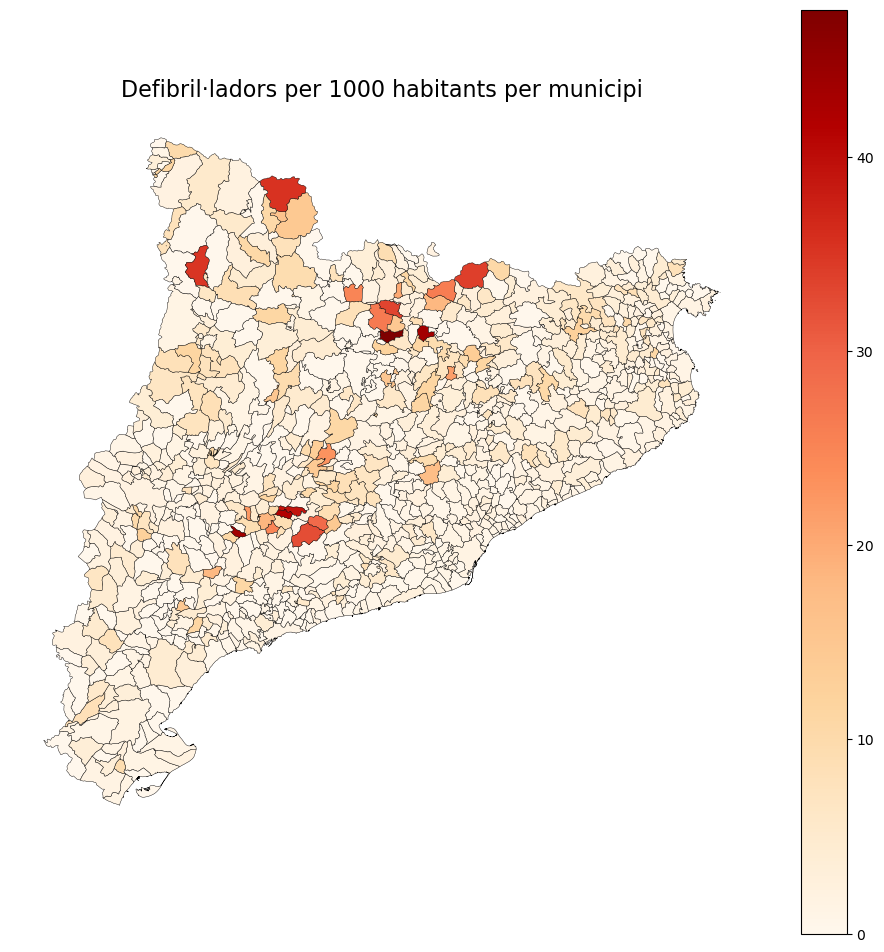

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

des_muni.plot(
    column="desf_per_1000",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("Defibril·ladors per 1000 habitants per municipi", fontsize=16)
ax.axis("off")
plt.show()

In [11]:
des_muni_hospi = des_muni.merge(
    df_hospis[["municipi", "hosp_count"]],
    left_on="NOMMUNI",
    right_on="municipi",
    how="left"
)

des_muni_hospi["hosp_count"] = des_muni_hospi["hosp_count"].fillna(0)
des_muni_hospi["desf_hosp"] = (des_muni_hospi["hosp_count"] + des_muni_hospi["desf_count"])/des_muni_hospi["pob"]*1000
des_muni_hospi["desf_hosp"] = des_muni_hospi["desf_hosp"].fillna(0)
#des_muni_hospi

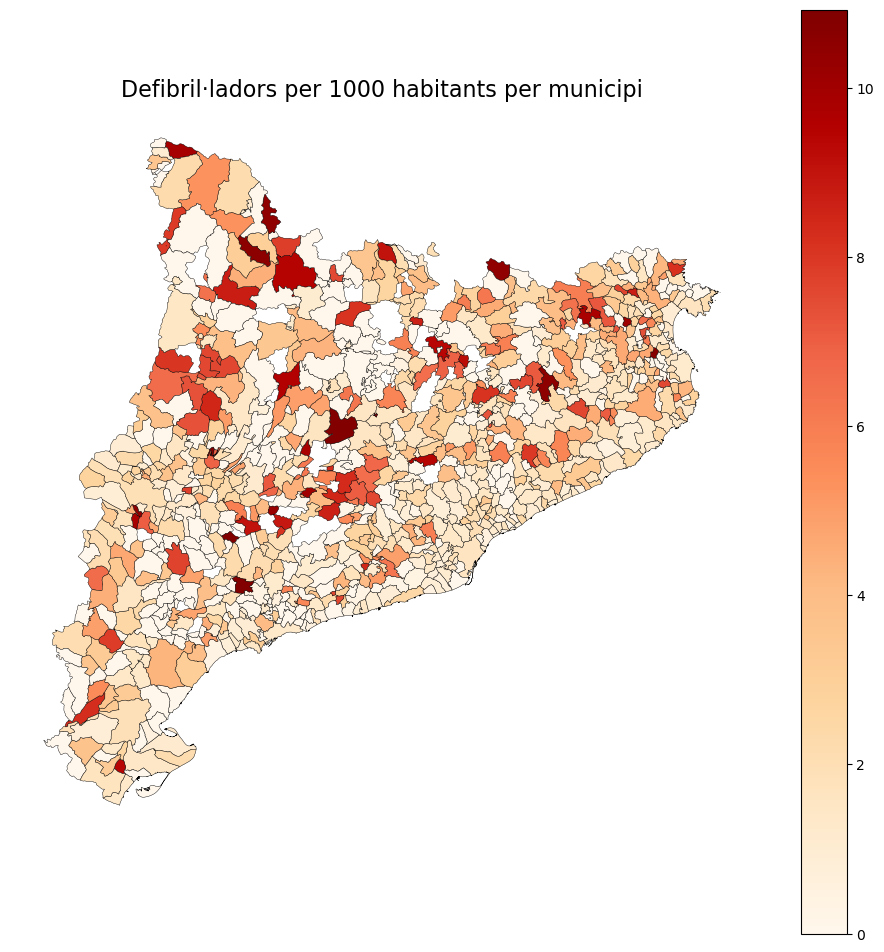

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))

# Compute the 95th percentile
threshold = des_muni_hospi["desf_hosp"].quantile(0.95)

# Keep only values below or equal to the 95th percentile
des_poc = des_muni_hospi[des_muni_hospi["desf_hosp"] <= threshold]

des_poc.plot(
    column="desf_hosp",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("Defibril·ladors per 1000 habitants per municipi", fontsize=16)
ax.axis("off")
plt.show()

In [13]:
des_molt = des_muni_hospi[des_muni_hospi["desf_hosp"] > 15]
#des_molt

In [14]:
des_muni_hospi.describe()

,AREAM5000,desf_per_1000,desf_count,pob,hosp_count,desf_hosp
count,947.000000,947.000000,947.000000,7.120000e+02,947.000000,947.000000
mean,33.901330,3.227203,11.066526,1.017618e+04,0.160507,3.232253
std,34.924715,5.277625,90.855232,6.650825e+04,1.231889,5.276304
min,0.628100,0.000000,0.000000,3.000000e+01,0.000000,0.000000
25%,12.353500,0.181139,1.000000,4.115000e+02,0.000000,0.181139
50%,22.748800,1.615509,2.000000,1.321000e+03,0.000000,1.638002
75%,43.007250,3.916002,7.000000,5.928500e+03,0.000000,3.916002
max,302.350300,47.619048,2722.000000,1.686208e+06,33.000000,47.619048


In [15]:
df_desfibriladors["titular"]


0                                      Ajuntament
1                           AJUNTAMENT DE TORTOSA
2                        Noel Alimentaria, S.A.U.
3                    AJUNTAMENT DE VILOBÍ D'ONYAR
4                           AJUNTAMENT DE CORBINS
                           ...                   
11489                   ACER COMPUTER IBERICA SAU
11490    AJUNTAMENT DE SANT SALVADOR DE GUARDIOLA
11491            AJUNTAMENT DE SANT PERE DE RIBES
11492                              MEIACOMPLEX SA
11493                      CARDIAC FUTURE IDEA SL
Name: titular, Length: 11494, dtype: object

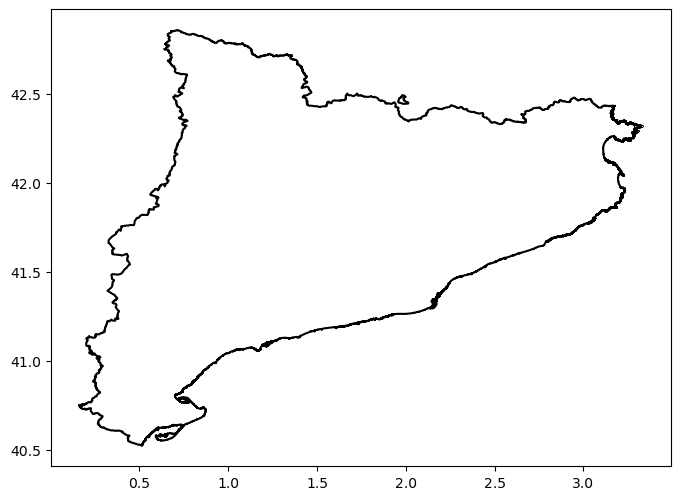

In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# Extract defibrillator coordinates
df_desf_coords = df_desfibriladors[['longitud', 'latitud']].copy()
df_desf_coords['longitud'] = pd.to_numeric(df_desf_coords['longitud'], errors='coerce')
df_desf_coords['latitud'] = pd.to_numeric(df_desf_coords['latitud'], errors='coerce')
df_desf_coords = df_desf_coords.dropna()
desf_points = df_desf_coords[['longitud', 'latitud']].values

# Read Catalonia boundary from JSON
import json
with open('carto/divisions-administratives-v2r1-catalunya-5000-20250730.json', 'r') as f:
    cat_geojson = json.load(f)

cat_geojson
#put geojson to geodataframe
cat_gdf = gpd.GeoDataFrame.from_features(cat_geojson["features"])

#plot boundary
fig, ax = plt.subplots(figsize=(8, 8))
cat_gdf.boundary.plot(ax=ax, color='black')
plt.show()

In [27]:


# Load municipality geometries
data_dir = "carto/"
municipis = gpd.read_file(data_dir + "muni.json")
municipis["NOMMUNI"] = municipis["NOMMUNI"].str.upper().str.strip()

# Calculate centroids for each municipality
municipis['centroid_lon'] = municipis.geometry.centroid.x
municipis['centroid_lat'] = municipis.geometry.centroid.y

# Prepare defibrillator data
df_desf_coords = df_desfibriladors.copy()
df_desf_coords['longitud'] = pd.to_numeric(df_desf_coords['longitud'], errors='coerce')
df_desf_coords['latitud'] = pd.to_numeric(df_desf_coords['latitud'], errors='coerce')
df_desf_coords['municipi'] = df_desf_coords['municipi'].str.upper().str.strip()

# Merge with municipality centroids
df_desf_coords = df_desf_coords.merge(
    municipis[['NOMMUNI', 'centroid_lon', 'centroid_lat']],
    left_on='municipi',
    right_on='NOMMUNI',
    how='left'
)

# Fill NaN coordinates with municipality centroids
df_desf_coords['longitud'] = df_desf_coords['longitud'].fillna(df_desf_coords['centroid_lon'])
df_desf_coords['latitud'] = df_desf_coords['latitud'].fillna(df_desf_coords['centroid_lat'])

# Remove any remaining NaN values
df_desf_coords = df_desf_coords.dropna(subset=['longitud', 'latitud'])

# Extract final coordinates
desf_points = df_desf_coords[['longitud', 'latitud']].values

print(f"Total defibrillators with coordinates: {len(desf_points)}")

# Get Catalonia bounds
min_lon, min_lat, max_lon, max_lat = municipis.total_bounds

# Create grid
grid_spacing = 0.01  # degrees (adjust for resolution)
lon_grid = np.arange(min_lon, max_lon, grid_spacing)
lat_grid = np.arange(min_lat, max_lat, grid_spacing)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
grid_points = np.c_[lon_mesh.ravel(), lat_mesh.ravel()]

# Find nearest defibrillator for each point
tree = cKDTree(desf_points)
distances, _ = tree.query(grid_points, k=1)




C:\Users\Ale\AppData\Local\Temp\ipykernel_6372\1462598448.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipis['centroid_lon'] = municipis.geometry.centroid.x
C:\Users\Ale\AppData\Local\Temp\ipykernel_6372\1462598448.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  municipis['centroid_lat'] = municipis.geometry.centroid.y


Total defibrillators with coordinates: 11461


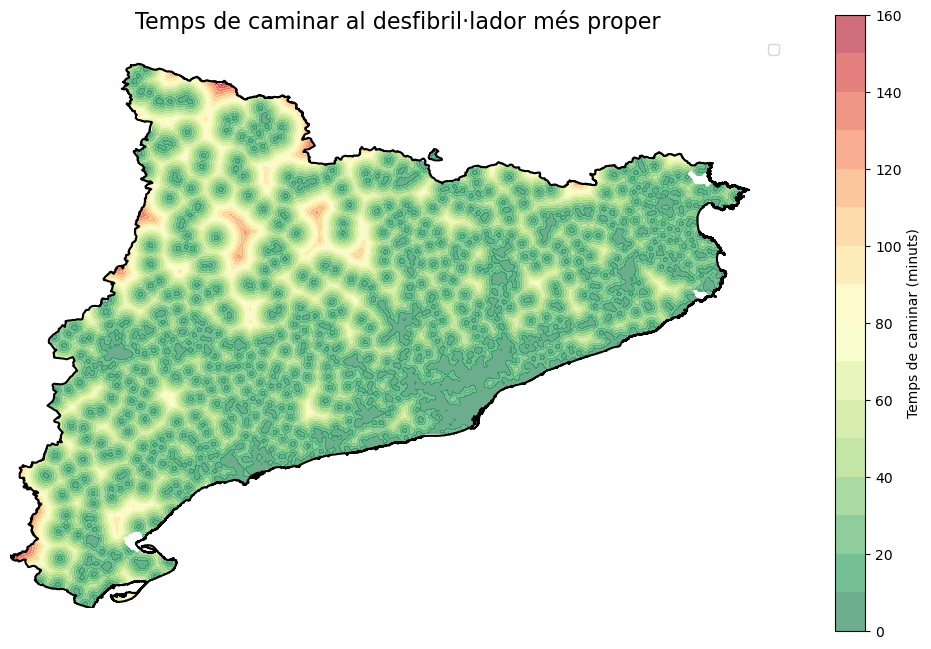

In [42]:
# Plot
fig, ax = plt.subplots(figsize=(10,8))

# Plot Catalonia boundary first
cat_gdf.boundary.plot(ax=ax, color='black')



# Convert to kilometers
lat_mean = np.mean(lat_mesh)
km_per_deg = 111.320 * np.cos(np.radians(lat_mean))
distances_km = distances * km_per_deg

# Convert to walking time at 5 km/h (in minutes)
time_minutes = (distances_km / 5) * 60
time_grid = time_minutes.reshape(lon_mesh.shape)

# Mask points outside Catalonia
from shapely.geometry import Point
municipis=municipis[municipis.is_valid]
catalonia_union = municipis.unary_union

#Just plot defibrillators inside catalonia
mask = np.zeros(time_grid.shape, dtype=bool)
for i in range(lon_mesh.shape[0]):
    for j in range(lon_mesh.shape[1]):
        point = Point(lon_mesh[i, j], lat_mesh[i, j])
        if not catalonia_union.contains(point):
            mask[i, j] = True
time_grid_masked = np.ma.array(time_grid, mask=mask)

# Plot
# Plot heatmap
contour = ax.contourf(
    lon_mesh, 
    lat_mesh, 
    time_grid_masked,
    levels=15,
    cmap='RdYlGn_r',
    alpha=0.6
)

# Add colorbar
cbar = plt.colorbar(contour, ax=ax, label='Temps de caminar (minuts)', shrink=0.8)

# Plot defibrillator points inside Catalonia
desf_gdf = gpd.GeoDataFrame(
    df_desf_coords,
    geometry=gpd.points_from_xy(df_desf_coords['longitud'], df_desf_coords['latitud']),
    crs=municipis.crs
)
desf_inside = desf_gdf[desf_gdf.geometry.within(catalonia_union)]

ax.set_title("Temps de caminar al desfibril·lador més proper", fontsize=16)
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.show()
